# Linear Similarity 

This notebooks explores the linear similarity (dot product) across different timestamps from the same variable with a configuration of the variable that relates highly to heatwaves (in the same timestamp).

In [1]:
import pandas as pd

import os
import numpy as np
import sys
import xarray as xr
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())
folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from IndexDrivers import calculate_anomalies

c:\Users\marti\Desktop\data\hw_extra


In [53]:
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_msl = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")

In [54]:
normalized_850 = calculate_anomalies(data_msl, [1972,2024], std=True)

## Vaguada Index Attempt

In [65]:
timestamp = "2017-06"

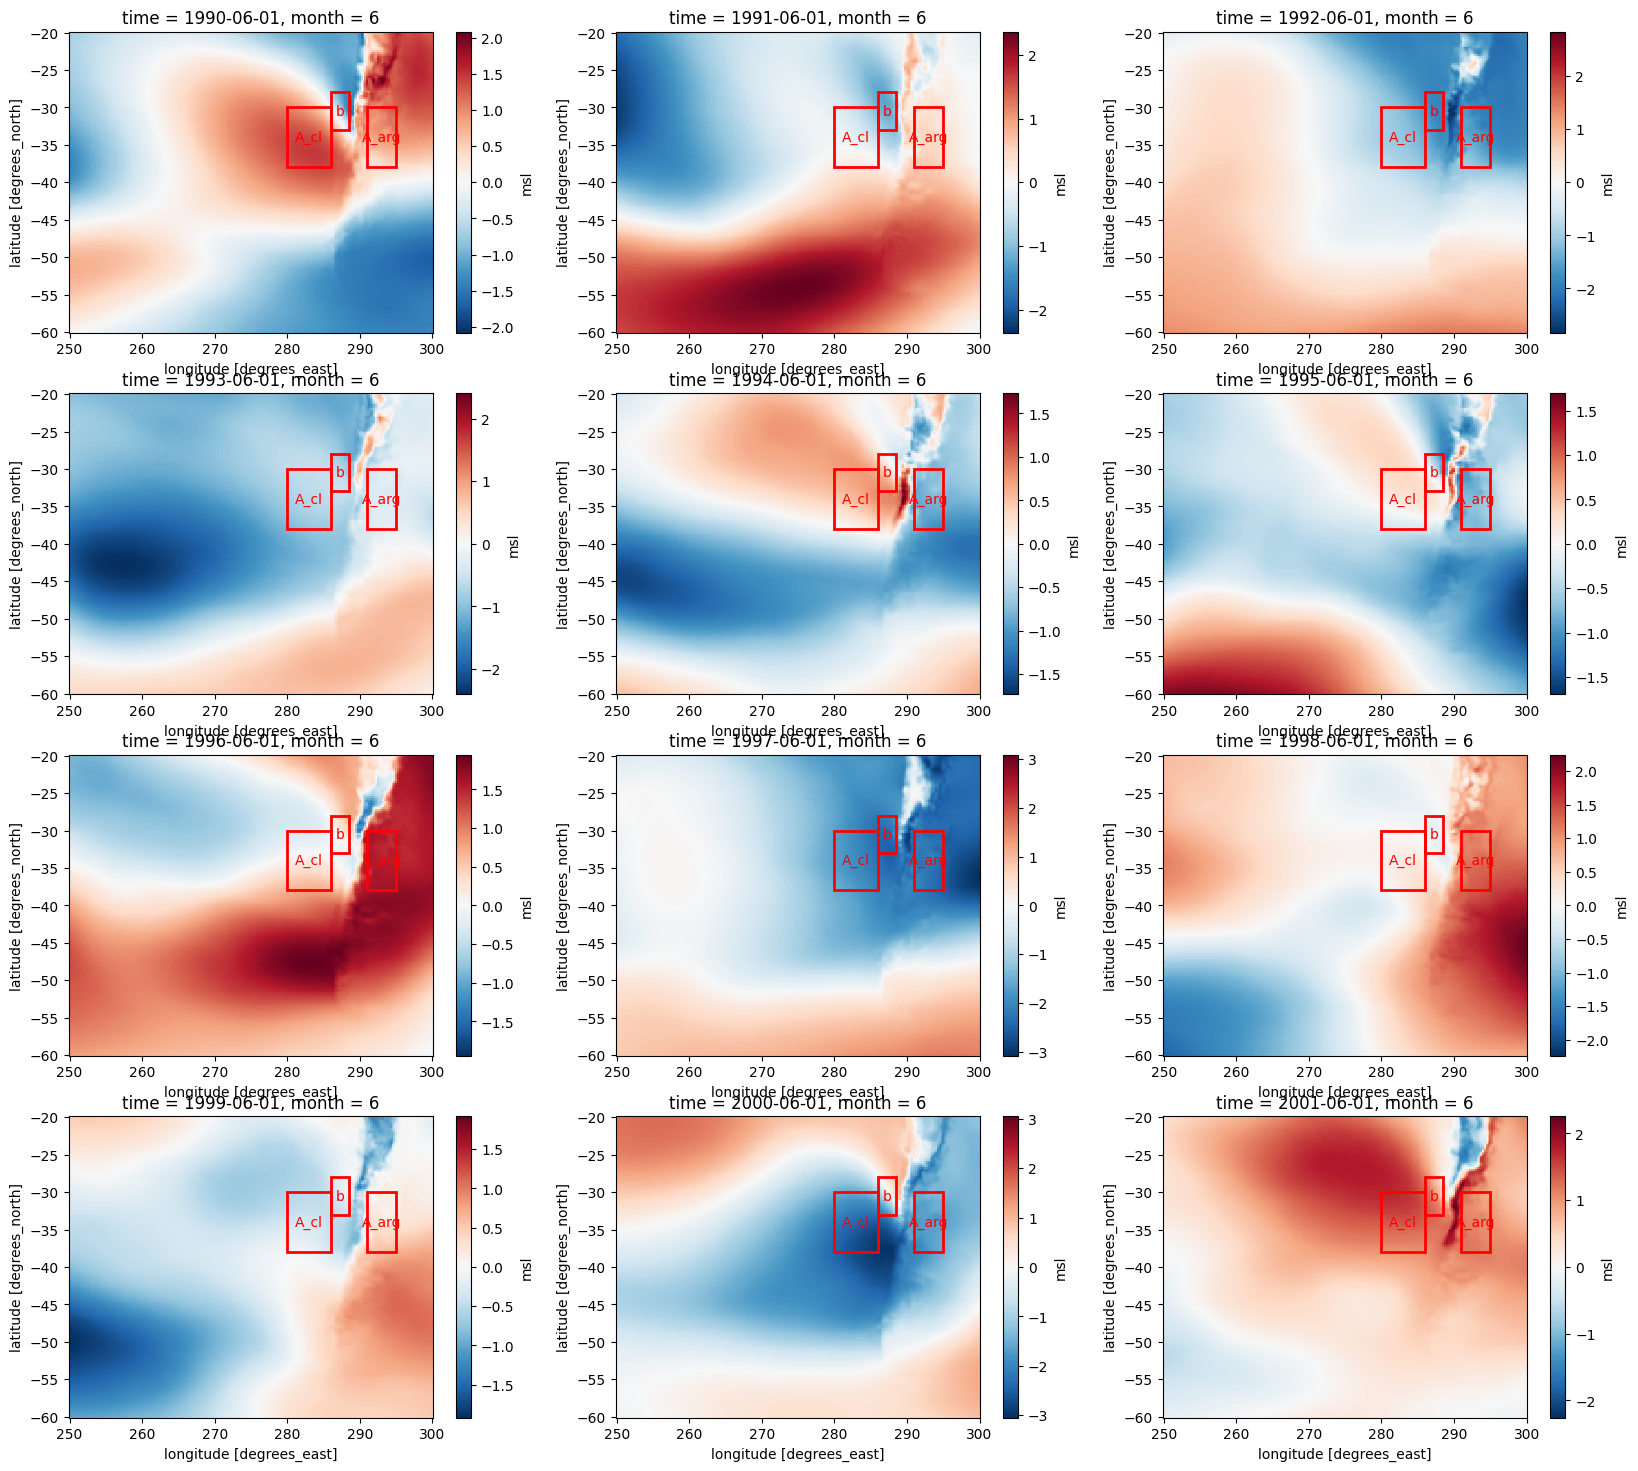

In [71]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

fig, ax = plt.subplots(4, 3, figsize=(20, 18))

times = [f"{1990+c}-06" for c in range(12)]
for i, timestamp in enumerate(times):
    normalized_850.sel(longitude=slice(250,310), latitude=slice(-60,-20), time=timestamp).msl.plot(ax=ax.flatten()[i])

    for box_id, coords in boxes_chile_vaguada.items():
        lon_min, lon_max, lat_min, lat_max = coords
        width = lon_max - lon_min
        height = lat_max - lat_min
        
        # Create rectangle patch
        rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                                fill=False, edgecolor='red', linewidth=2)
        ax.flatten()[i].add_patch(rect)
        
        # Optionally add a label
        ax.flatten()[i].text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
                ha='center', va='center', color='red')

plt.show()

Apparently June on years 1990, 1996, 1998 and 2001 have some sort of vaguada configuration. These are potential point references.

In [79]:
def vaguada_index(datamsl, box_low, boxes_high):
    b_ts = datamsl.sel(longitude=slice(box_low[0], box_low[1]), latitude=slice(box_low[2], box_low[3])).mean(dim=["longitude", "latitude"]).to_numpy()

    a_tss = [datamsl.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3])).mean(dim=["longitude", "latitude"]).to_numpy() for box in boxes_high]

    A_ts = np.mean(a_tss, axis=0)
    return A_ts - b_ts

vag_index = vaguada_index(normalized_850.msl, boxes_chile_vaguada["b"], [boxes_chile_vaguada["A_arg"], boxes_chile_vaguada["A_cl"]])

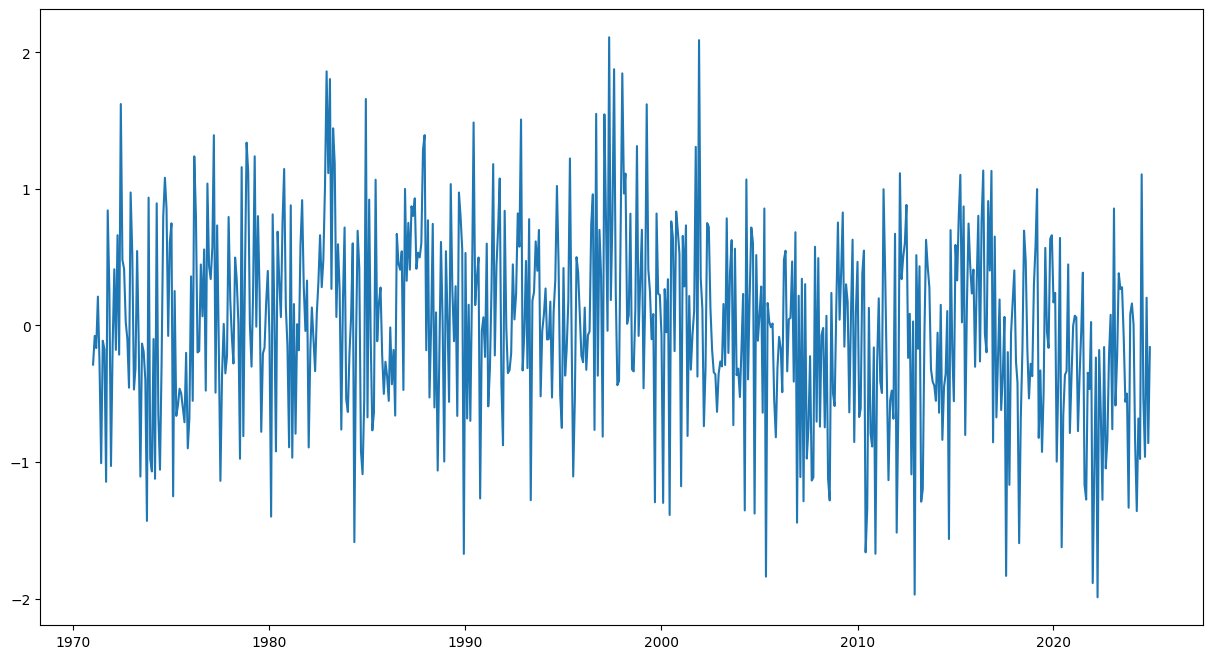

In [81]:
fig, axs = plt.subplots( figsize=(15,8))
axs.plot(normalized_850.time, vag_index)

## Vaguada Configuration

In [55]:
timestamp_hw = "2022-10"

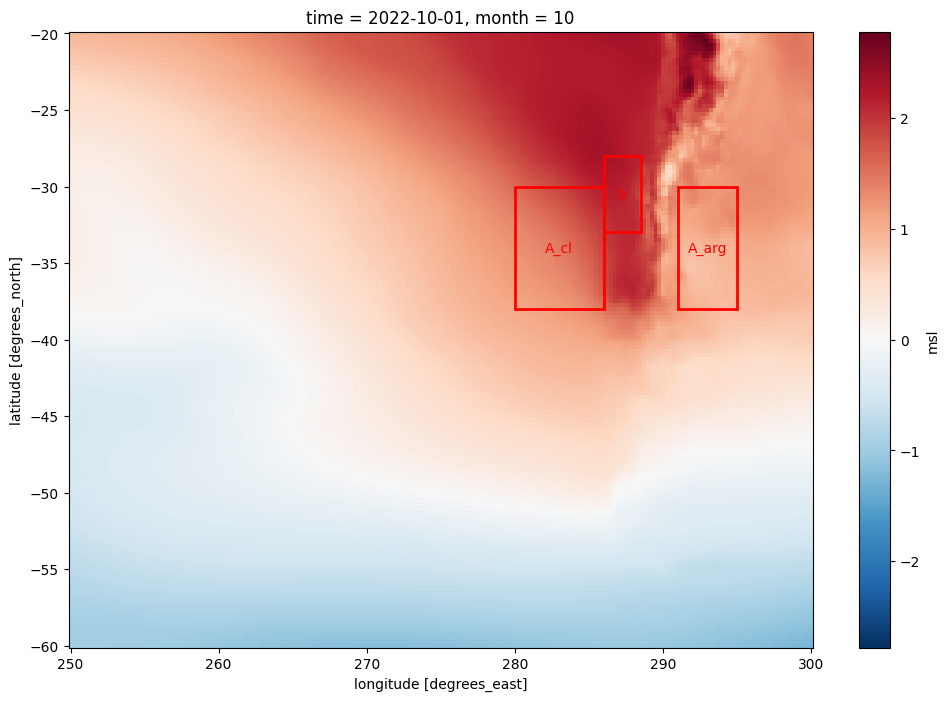

In [56]:
boxes_chile_vaguada = {
    "b": [286, 288.5, -33, -28],
    "A_cl": [280, 286, -38,-30], #test bigger A boxes
    "A_arg": [291, 295, -38, -30]
}

fig, ax = plt.subplots(figsize=(12, 8))

normalized_850.sel(longitude=slice(250,310), latitude=slice(-60,-20), time=timestamp_hw).msl.plot(ax=ax)

for box_id, coords in boxes_chile_vaguada.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

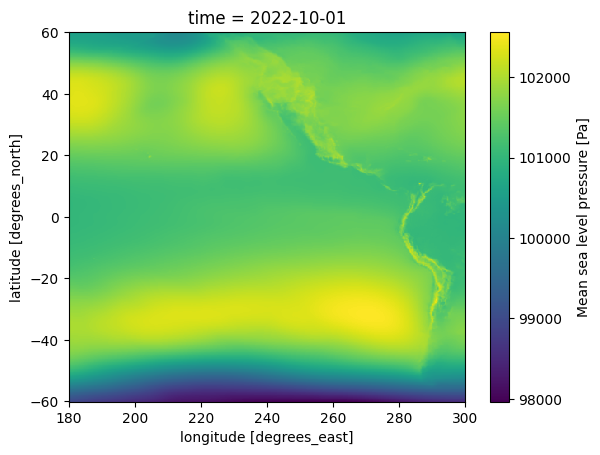

In [57]:
data_msl.sel(time=timestamp_hw).msl.plot()

In [ ]:
anomalies = normalized_850
box = boxes_chile_vaguada["b"]
b_data = anomalies.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
box = boxes_chile_vaguada["A_cl"]
acl_data = anomalies.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
box = boxes_chile_vaguada["A_arg"]
aarg_data = anomalies.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [10]:
b = b_data.sel(time=timestamp_hw).msl.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
acl = acl_data.sel(time=timestamp_hw).msl.to_numpy().reshape(acl_data.sizes["latitude"], acl_data.sizes["longitude"])
aarg = aarg_data.sel(time=timestamp_hw).msl.to_numpy().reshape(aarg_data.sizes["latitude"], aarg_data.sizes["longitude"])

In [11]:
vector_hw = np.concatenate([b.flatten(), acl.flatten(), aarg.flatten()])

In [12]:
timeserie = []
for time_element in data_msl.msl:
    box = boxes_chile_vaguada["b"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    box = boxes_chile_vaguada["A_cl"]
    acl_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    box = boxes_chile_vaguada["A_arg"]
    aarg_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = [data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"]) for data in [b_data, acl_data, aarg_data]]
    element = np.concatenate([el.flatten() for el in element])
    timeserie.append(np.dot(vector_hw, element))

In [13]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

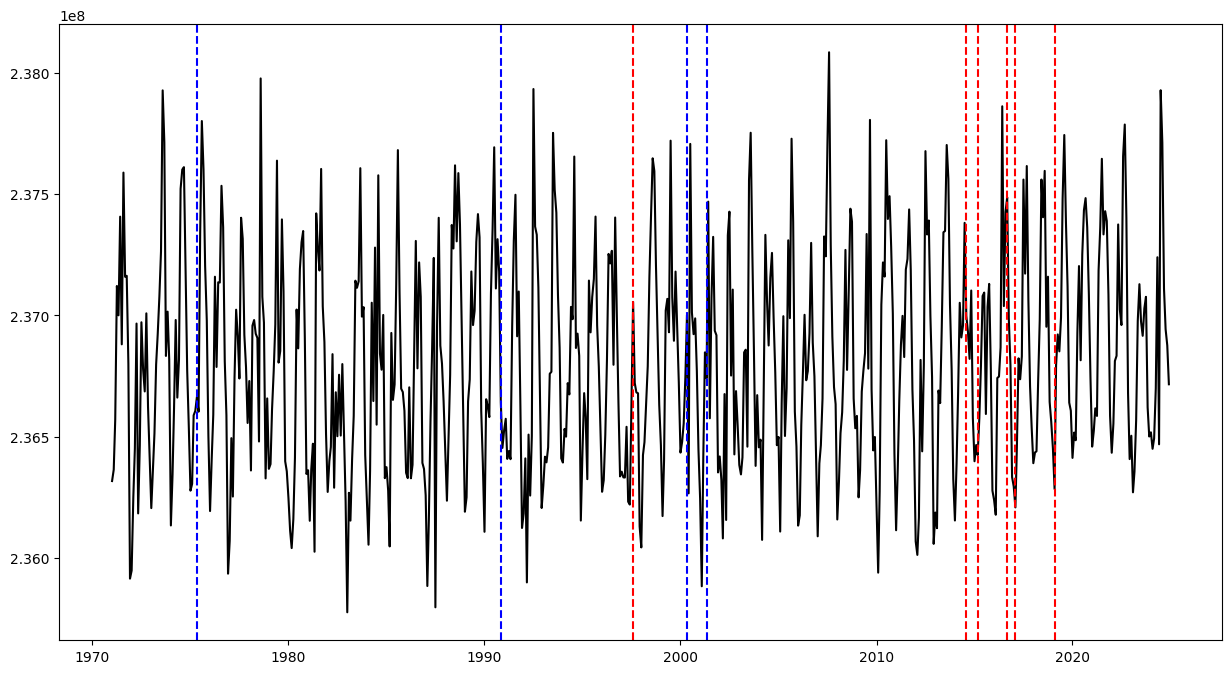

In [14]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_msl.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [15]:
timeserie = []
for time_element in anomalies.msl:
    box = boxes_chile_vaguada["b"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    box = boxes_chile_vaguada["A_cl"]
    acl_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    box = boxes_chile_vaguada["A_arg"]
    aarg_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = [data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"]) for data in [b_data, acl_data, aarg_data]]
    element = np.concatenate([el.flatten() for el in element])
    timeserie.append(np.dot(vector_hw, element))

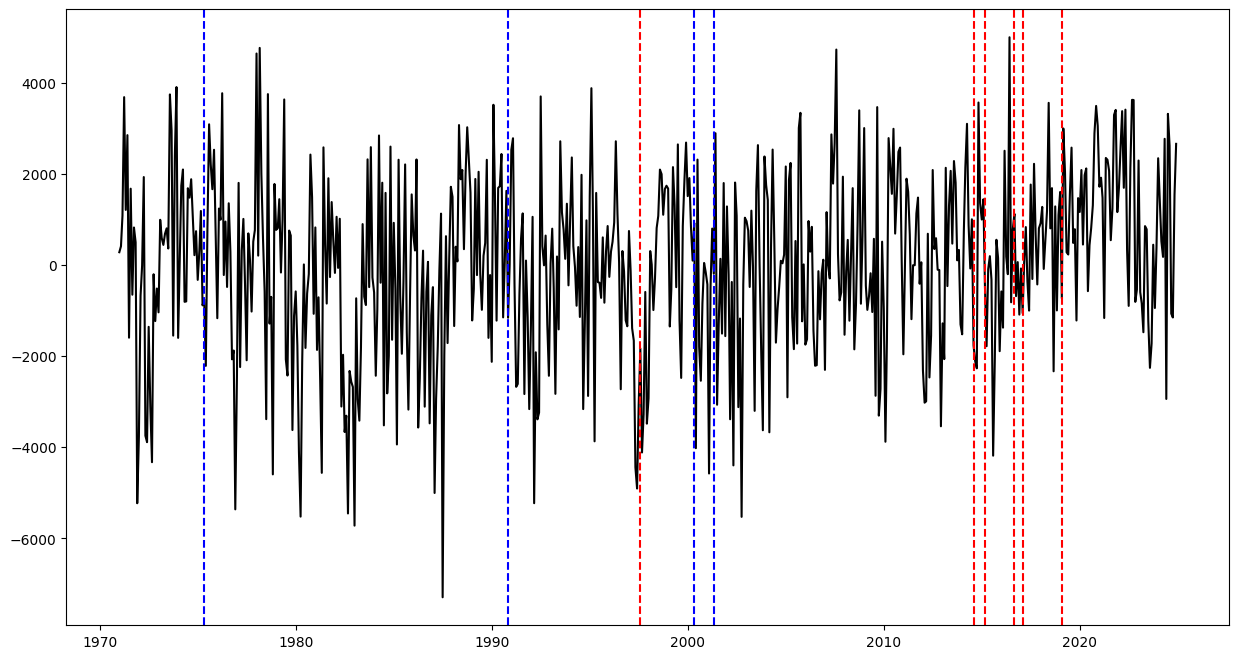

In [16]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_msl.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [17]:
def is_month(month, n):
    return month == n

In [18]:
timeserie_seasons = {}
normalized = calculate_anomalies(data_msl, [1972,2024], std=True).msl
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, data in seasons.items():
    timeserie = []
    for time_element in data:
        box = boxes_chile_vaguada["b"]
        b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        box = boxes_chile_vaguada["A_cl"]
        acl_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        box = boxes_chile_vaguada["A_arg"]
        aarg_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = [data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"]) for data in [b_data, acl_data, aarg_data]]
        element = np.concatenate([el.flatten() for el in element])
        timeserie.append(np.dot(vector_hw, element))
    timeserie_seasons[season] = timeserie

In [19]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

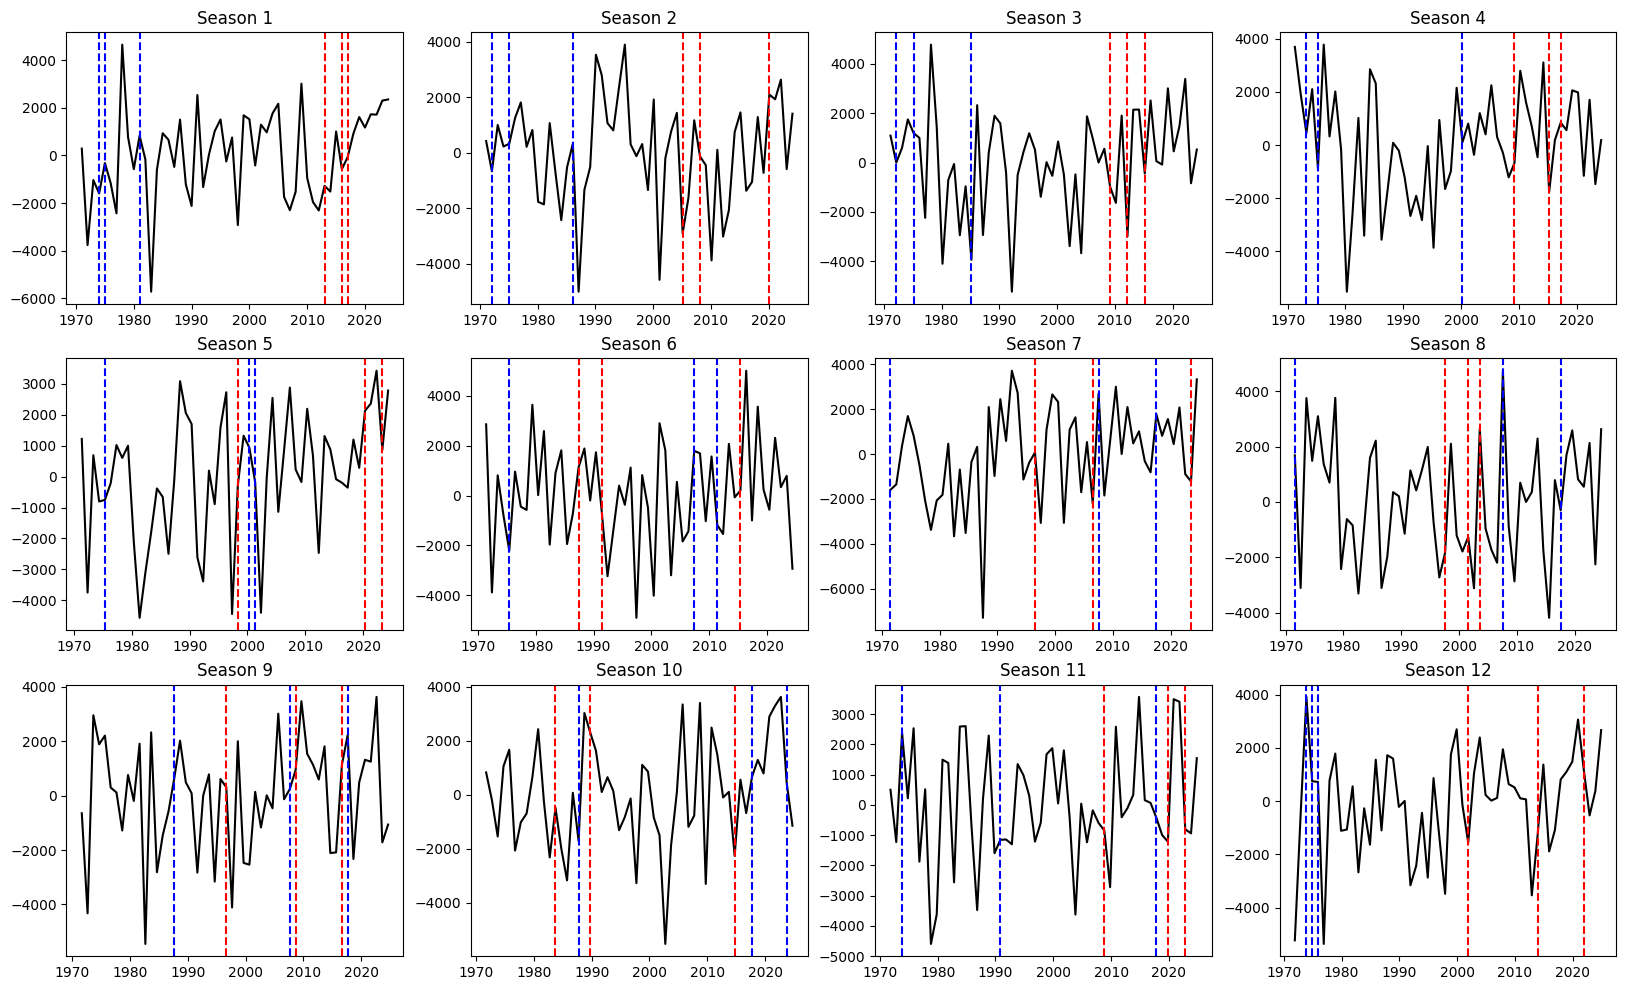

In [20]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

## Advection Configuration

In [21]:
data_850 = calculate_anomalies(data_850, [1972,2024], std=True)

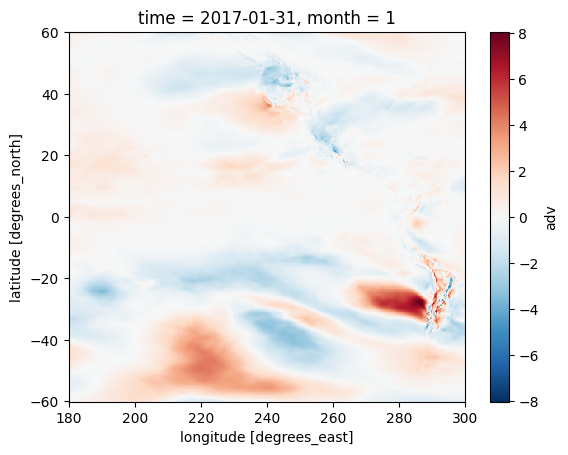

In [22]:
timestamp_hw = "2017-01"
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time=timestamp_hw).plot()

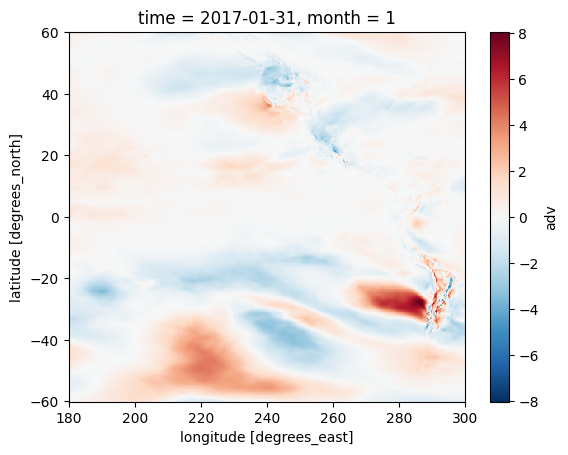

In [23]:
timestamp_hw = "2017-01"
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time=timestamp_hw).plot()

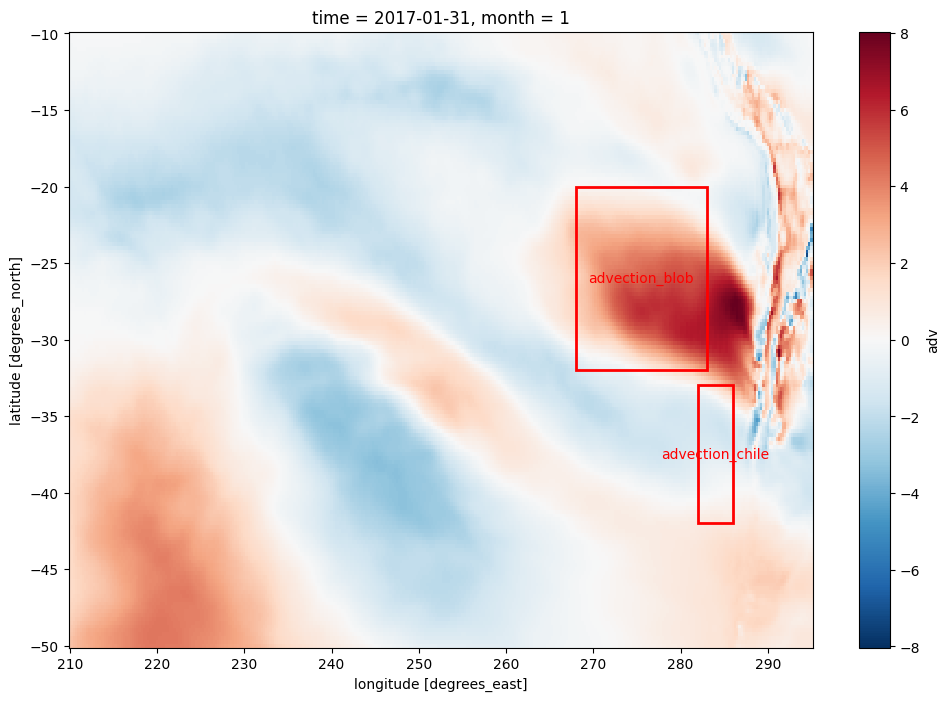

In [24]:
boxes_chile_adv = {
    "advection_chile": [282, 286, -42, -33],
    "advection_blob": [268, 283, -32, -20]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(210,295), latitude=slice(-50,-10), time="2017-01").adv.plot(ax=ax)

for box_id, coords in boxes_chile_adv.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [25]:
box = boxes_chile_adv["advection_blob"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [26]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [27]:
vector_hw = b.flatten()

In [28]:
timeserie = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_blob"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie.append(np.dot(vector_hw, element.flatten()))

In [29]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

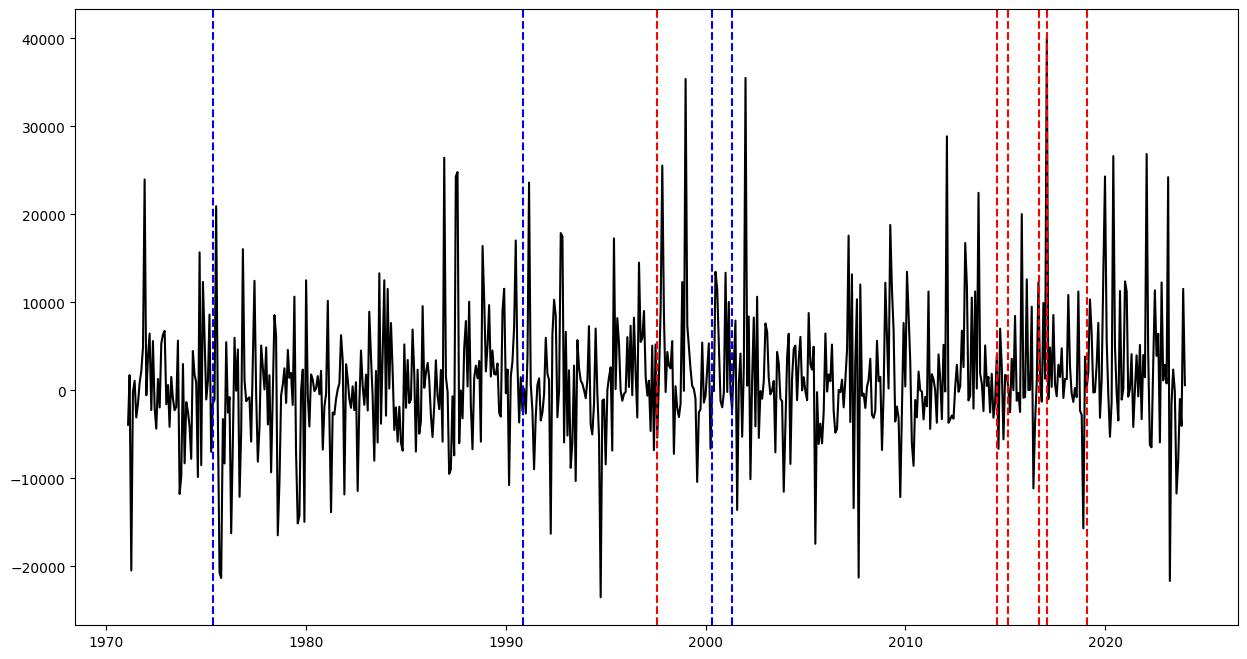

In [30]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [31]:
def is_month(month, n):
    return month == n

In [32]:
timeserie_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_blob"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_seasons[season] = timeserie

In [33]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

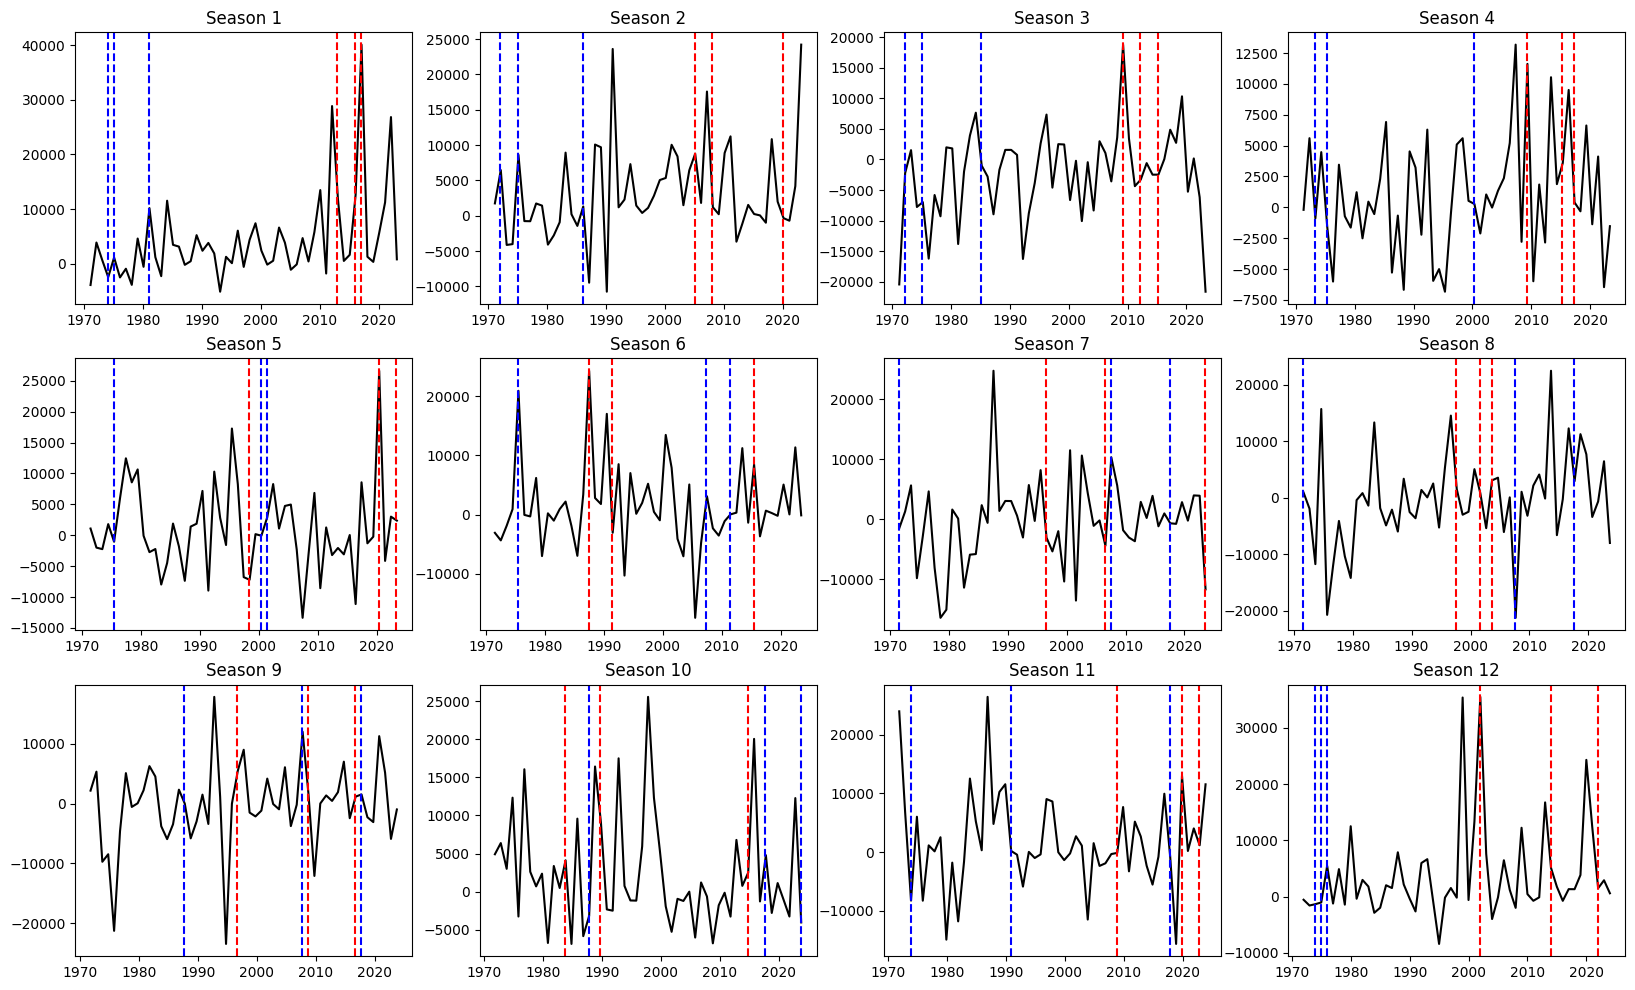

In [34]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')

In [35]:
box = boxes_chile_adv["advection_chile"]
adv_data = data_850.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))

In [36]:
b = adv_data.sel(time=timestamp_hw).adv.to_numpy().reshape(adv_data.sizes["latitude"], adv_data.sizes["longitude"])

In [37]:
vector_hw = b.flatten()

In [38]:
timeserie = []
for time_element in data_850.adv:
    box = boxes_chile_adv["advection_chile"]
    b_data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
    element = b_data.to_numpy().reshape(b_data.sizes["latitude"], b_data.sizes["longitude"])
    timeserie.append(np.dot(vector_hw, element.flatten()))

In [39]:
high_hws_dates = ["2015-03-01", "2016-09-01", "1997-08-01", "2017-02-01", "2019-02-01", "2014-08-01"]
low_hws_date = ["2000-05-01", "1990-11-01", "2001-05-01", "1975-05-01"]

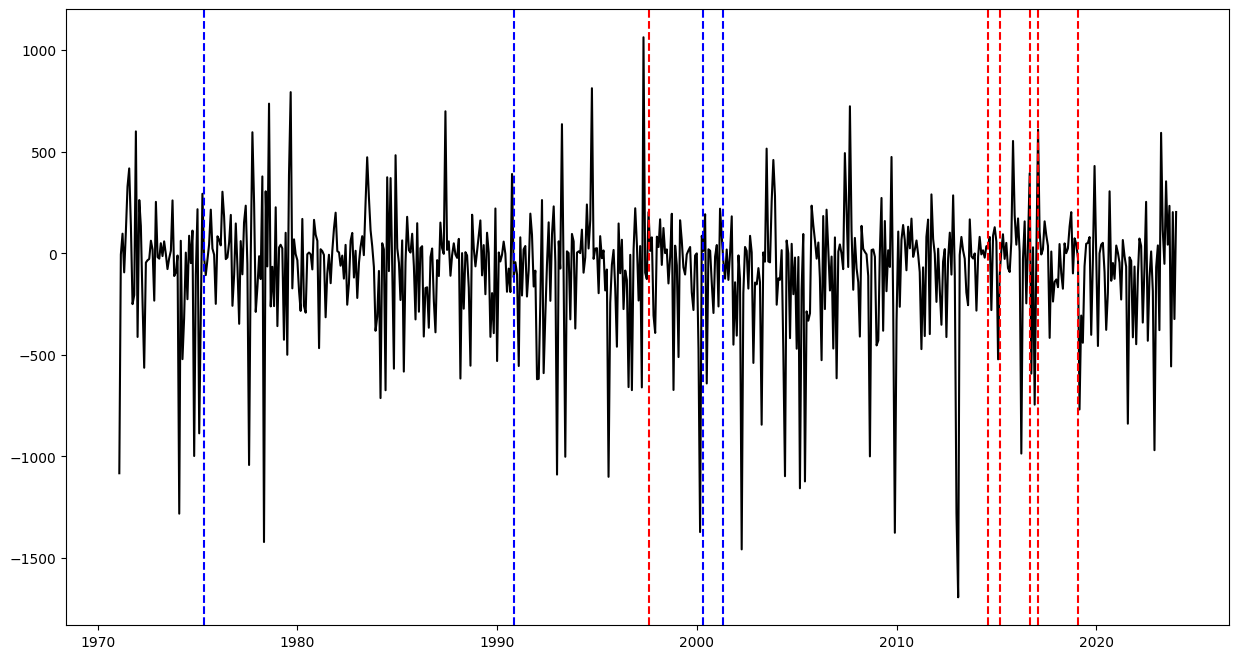

In [40]:
fig, axs = plt.subplots(figsize=(15,8))
axs.plot(data_850.time, timeserie, c="black")
for date in high_hws_dates:
    axs.axvline(pd.to_datetime(date), color="red", ls='--')
for date in low_hws_date:
    axs.axvline(pd.to_datetime(date), color="blue", ls='--')

In [41]:
def is_month(month, n):
    return month == n

In [42]:
timeserie_seasons = {}
normalized = data_850.adv
seasons = {i: normalized.sel(time=is_month(normalized['time.month'], i)) for i in range(1,13)}
for season, datas in seasons.items():
    timeserie = []
    for time_element in datas:
        box = boxes_chile_adv["advection_chile"]
        data = time_element.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2],box[3]))
        element = data.to_numpy().reshape(data.sizes["latitude"], data.sizes["longitude"])
        timeserie.append(np.dot(vector_hw, element.flatten()))
    timeserie_seasons[season] = timeserie

In [43]:
hws_dates = {1: ['2016-01-01', '2017-01-01', '2013-01-01'],
             2: ['2020-02-01', '2005-02-01', '2008-02-01'],
             3: ['2015-03-01', '2009-03-01', '2012-03-01'],
             4: ['2009-04-01', '2017-04-01', '2015-04-01'],
             5: ['2020-05-01', '1998-05-01', '2023-05-01'],
             6: ['1987-06-01', '2015-06-01', '1991-06-01'],
             7: ['2023-07-01', '2006-07-01', '1996-07-01'],
             8: ['1997-08-01', '2001-08-01', '2003-08-01'],
             9: ['2016-09-01', '2008-09-01', '1996-09-01'],
             10: ['1983-10-01', '1989-10-01', '2014-10-01'],
             11: ['2019-11-01', '2008-11-01', '2022-11-01'],
             12: ['2021-12-01', '2001-12-01', '2013-12-01']}

non_hws_dates = {1: ['1975-01-01', '1974-01-01', '1981-01-01'],
             2: ['1975-02-01', '1972-02-01', '1986-02-01'],
             3: ['1975-03-01', '1972-03-01', '1985-03-01'],
             4: ['1975-04-01', '1973-04-01', '2000-04-01'],
             5: ['2000-05-01', '2001-05-01', '1975-05-01'],
             6: ['2007-06-01', '1975-06-01', '2011-06-01'],
             7: ['1971-07-01', '2017-07-01', '2007-07-01'],
             8: ['2017-08-01', '2007-08-01', '1971-08-01'],
             9: ['2007-09-01', '1987-09-01', '2017-09-01'],
             10: ['2023-10-01', '2017-10-01', '1987-10-01'],
             11: ['1990-11-01', '2017-11-01', '1973-11-01'],
             12: ['1975-12-01', '1973-12-01', '1974-12-01']}

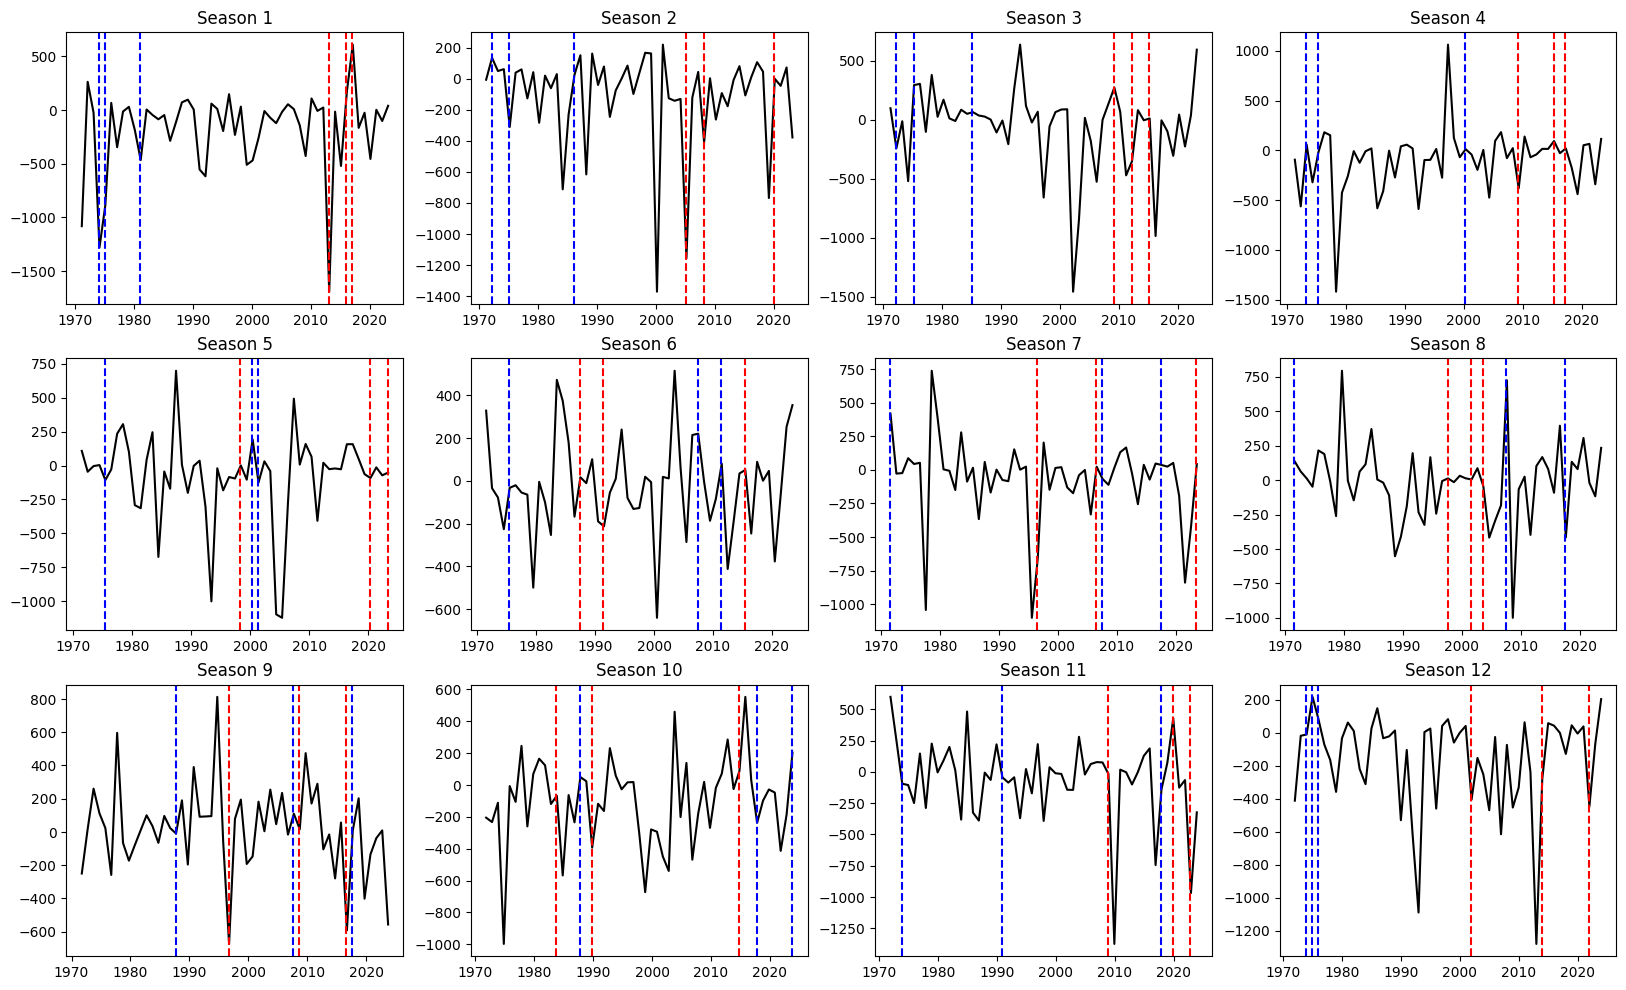

In [44]:
fig, axs = plt.subplots(3,4, figsize=(20,12))
for season, ts in timeserie_seasons.items():
    axs.flatten()[season-1].plot(seasons[season].time, ts, c="black")
    axs.flatten()[season-1].set_title(f"Season {season}")
for season, dates in hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="red", ls='--')
for season, dates in non_hws_dates.items():
    for d in dates:
        axs.flatten()[season-1].axvline(pd.to_datetime(d), color="blue", ls='--')